In [ ]:

# !pip install -qU \
#   langchain-core==0.3.33 \
#   langchain-openai==0.3.3 \
#   langchain-community==0.3.16

In [62]:
import getpass
import os

if not os.environ.get("GOOGLE_API_KEY"):
  os.environ["GOOGLE_API_KEY"] = getpass.getpass("Enter API key for Google Gemini: ")

from langchain.chat_models import init_chat_model

llm = init_chat_model("gemini-2.5-flash", model_provider="google_genai", temperature=0)


creative_llm = init_chat_model("gemini-2.5-flash", model_provider="google_genai", temperature=0.9)

We will be taking an `article` _draft_ and using LangChain to generate various useful items around this article. We'll be creating:

1. An article title
2. An article description
3. Editor advice where we will insert an additional paragraph in the article
4. A thumbnail / hero image for our article.

In [3]:
article = """
\
We believe AI's short—to mid-term future belongs to agents and that the long-term future of *AGI* may evolve from agentic systems. Our definition of agents covers any neuro-symbolic system in which we merge neural AI (such as an LLM) with semi-traditional software.

With agents, we allow LLMs to integrate with code — allowing AI to search the web, perform math, and essentially integrate into anything we can build with code. It should be clear the scope of use cases is phenomenal where AI can integrate with the broader world of software.

In this introduction to AI agents, we will cover the essential concepts that make them what they are and why that will make them the core of real-world AI in the years to come.

---

## Neuro-Symbolic Systems

Neuro-symbolic systems consist of both neural and symbolic computation, where:

- Neural refers to LLMs, embedding models, or other neural network-based models.
- Symbolic refers to logic containing symbolic logic, such as code.

Both neural and symbolic AI originate from the early philosophical approaches to AI: connectionism (now neural) and symbolism. Symbolic AI is the more traditional AI. Diehard symbolists believed they could achieve true AGI via written rules, ontologies, and other logical functions.

The other camp were the connectionists. Connectionism emerged in 1943 with a theoretical neural circuit but truly kicked off with Rosenblatt's perceptron paper in 1958 [1][2]. Both of these approaches to AI are fascinating but deserve more time than we can give them here, so we will leave further exploration of these concepts for a future chapter.

Most important to us is understanding where symbolic logic outperforms neural-based compute and vice-versa.

| Neural | Symbolic |
| --- | --- |
| Flexible, learned logic that can cover a huge range of potential scenarios. | Mostly hand-written rules which can be very granular and fine-tuned but hard to scale. |
| Hard to interpret why a neural system does what it does. Very difficult or even impossible to predict behavior. | Rules are written and can be understood. When unsure why a particular ouput was produced we can look at the rules / logic to understand. |
| Requires huge amount of data and compute to train state-of-the-art neural models, making it hard to add new abilities or update with new information. | Code is relatively cheap to write, it can be updated with new features easily, and latest information can often be added often instantaneously. |
| When trained on broad datasets can often lack performance when exposed to unique scenarios that are not well represented in the training data. | Easily customized to unique scenarios. |
| Struggles with complex computations such as mathematical operations. | Perform complex computations very quickly and accurately. |

Pure neural architectures struggle with many seemingly simple tasks. For example, an LLM *cannot* provide an accurate answer if we ask it for today's date.

Retrieval Augmented Generation (RAG) is commonly used to provide LLMs with up-to-date knowledge on a particular subject or access to proprietary knowledge.

### Giving LLMs Superpowers

By 2020, it was becoming clear that neural AI systems could not perform tasks symbolic systems typically excelled in, such as arithmetic, accessing structured DB data, or making API calls. These tasks require discrete input parameters that allow us to process them reliably according to strict written logic.

In 2022, researchers at AI21 developed Jurassic-X, an LLM-based "neuro-symbolic architecture." Neuro-symbolic refers to merging the "neural computation" of large language models (LLMs) with more traditional (i.e. symbolic) computation of code.

Jurassic-X used the Modular Reasoning, Knowledge, and Language (MRKL) system [3]. The researchers developed MRKL to solve the limitations of LLMs, namely:

- Lack of up-to-date knowledge, whether that is the latest in AI or something as simple as today's date.
- Lack of proprietary knowledge, such as internal company docs or your calendar bookings.
- Lack of reasoning, i.e. the inability to perform operations that traditional software is good at, like running complex mathematical operations.
- Lack of ability to generalize. Back in 2022, most LLMs had to be fine-tuned to perform well in a specific domain. This problem is still present today but far less prominent as the SotA models generalize much better and, in the case of MRKL, are able to use tools relatively well (although we could certainly take the MRKL solution to improve tool use performance even today).

MRKL represents one of the earliest forms of what we would now call an agent; it is an LLM (neural computation) paired with executable code (symbolic computation).

## ReAct and Tools

There is a misconception in the broader industry that an AI agent is an LLM contained within some looping logic that can generate inputs for and execute code functions. This definition of agents originates from the huge popularity of the ReAct agent framework and the adoption of a similar structure with function/tool calling by LLM providers such as OpenAI, Anthropic, and Ollama.

![ReAct agent flow with the Reasoning-Action loop [4]. When the action chosen specifies to use a normal tool, the tool is used and the observation returned for another iteration through the Reasoning-Action loop. To return a final answer to the user the LLM must choose action "answer" and provide the natural language response, finishing the loop.](/images/posts/ai-agents/ai-agents-00.png)

<small>ReAct agent flow with the Reasoning-Action loop [4]. When the action chosen specifies to use a normal tool, the tool is used and the observation returned for another iteration through the Reasoning-Action loop. To return a final answer to the user the LLM must choose action "answer" and provide the natural language response, finishing the loop.</small>

Our "neuro-symbolic" definition is much broader but certainly does include ReAct agents and LLMs paired with tools. This agent type is the most common for now, so it's worth understanding the basic concept behind it.

The **Re**ason **Act**ion (ReAct) method encourages LLMs to generate iterative *reasoning* and *action* steps. During *reasoning,* the LLM describes what steps are to be taken to answer the user's query. Then, the LLM generates an *action,* which we parse into an input to some executable code, which we typically describe as a tool/function call.

![ReAct method. Each iteration includes a Reasoning step followed by an Action (tool call) step. The Observation is the output from the previous tool call. During the final iteration the agent calls the answer tool, meaning we generate the final answer for the user.](/images/posts/ai-agents/ai-agents-01.png)

<small>ReAct method. Each iteration includes a Reasoning step followed by an Action (tool call) step. The Observation is the output from the previous tool call. During the final iteration the agent calls the answer tool, meaning we generate the final answer for the user.</small>

Following the reason and action steps, our action tool call returns an observation. The logic returns the observation to the LLM, which is then used to generate subsequent reasoning and action steps.

The ReAct loop continues until the LLM has enough information to answer the original input. Once the LLM reaches this state, it calls a special *answer* action with the generated answer for the user.

## Not only LLMs and Tool Calls

LLMs paired with tool calling are powerful but far from the only approach to building agents. Using the definition of neuro-symbolic, we cover architectures such as:

- Multi-agent workflows that involve multiple LLM-tool (or other agent structure) combinations.
- More deterministic workflows where we may have set neural model-tool paths that may fork or merge as the use case requires.
- Embedding models that can detect user intents and decide tool-use or LLM selection-based selection in vector space.

These are just a few high-level examples of alternative agent structures. Far from being designed for niche use cases, we find these alternative options to frequently perform better than the more common ReAct or Tool agents. We will cover all of these examples and more in future chapters.

---

Agents are fundamental to the future of AI, but that doesn't mean we should expect that future to come from agents in their most popular form today. ReAct and Tool agents are great and handle many simple use cases well, but the scope of agents is much broader, and we believe thinking beyond ReAct and Tools is key to building future AI.

---

You can sign up for the [Aurelio AI newsletter](https://b0fcw9ec53w.typeform.com/to/w2BDHVK7) to stay updated on future releases in our comprehensive course on agents.

---

## References

[1] The curious case of Connectionism (2019) [https://www.degruyter.com/document/doi/10.1515/opphil-2019-0018/html](https://www.degruyter.com/document/doi/10.1515/opphil-2019-0018/html)

[2] F. Rosenblatt, [The Perceptron: A Probabilistic Model for Information Storage and Organization in the Brain](https://www.ling.upenn.edu/courses/cogs501/Rosenblatt1958.pdf) (1958), Psychological Review

[3] E. Karpas et al. [MRKL Systems: A Modular, Neuro-Symbolic Architecture That Combines Large Language Models, External Knowledge Sources and Discrete Reasoning](https://arxiv.org/abs/2205.00445) (2022), AI21 Labs
"""

LangChain comes with several prompt classes and methods for organizing or constructing our prompts. We will cover these in more detail in later examples, but for now we'll cover the essentials that we need here.

Prompts for chat agents are at a minimum broken up into three components, those are:

* System prompt: this provides the instructions to our LLM on how it must behave, what it's objective is, etc.

* User prompt: this is a user written input.

* AI prompt: this is the AI generated output. When representing a conversation, previous generations will be inserted back into the next prompt and become part of the broader _chat history_.

```
You are a helpful AI assistant, you will do XYZ.    | SYSTEM PROMPT

User: Hi, what is the capital of Australia?         | USER PROMPT
AI: It is Canberra                                  | AI PROMPT
User: When is the best time to visit?               | USER PROMPT
```

LangChain provides us with _templates_ for each of these prompt types. By using templates we can insert different inputs to the template, modifying the prompt based on the provided inputs.

Let's initialize our system and user prompt first:

In [ ]:
from langchain.prompts import SystemMessagePromptTemplate, HumanMessagePromptTemplate

# Defining the system prompt (how the AI should act)
system_prompt = SystemMessagePromptTemplate.from_template(
    "You are an AI assistant that helps generate article titles."
)

# the user prompt is provided by the user, in this case however the only dynamic
# input is the article
user_prompt = HumanMessagePromptTemplate.from_template(
    """You are tasked with creating a name for a article.
The article is here for you to examine {article}

The name should be based of the context of the article.
Be creative, but make sure the names are clear, catchy,
and relevant to the theme of the article.

Only output the article name, no other explanation or
text can be provided.""",
    input_variables=["article"]
)


In [11]:
user_prompt.format(article="TEST STRING")

HumanMessage(content='You are tasked with creating a name for a article.\nThe article is here for you to examine TEST STRING\n\nThe name should be based of the context of the article.\nBe creative, but make sure the names are clear, catchy,\nand relevant to the theme of the article.\n\nOnly output the article name, no other explanation or\ntext can be provided.', additional_kwargs={}, response_metadata={})

We have our system and user prompts, we can merge both into our full chat prompt using the `ChatPromptTemplate`:

In [17]:
from langchain.prompts import ChatPromptTemplate

first_prompt = ChatPromptTemplate.from_messages([system_prompt, user_prompt])

By default, the `ChatPromptTemplate` will read the `input_variables` from each of the prompt templates inserted and allow us to use those input variables when formatting the full chat prompt template:

In [18]:
print(first_prompt.format(article="TEST STRING"))

System: You are an AI assistant that helps generate article titles.
Human: You are tasked with creating a name for a article.
The article is here for you to examine TEST STRING

The name should be based of the context of the article.
Be creative, but make sure the names are clear, catchy,
and relevant to the theme of the article.

Only output the article name, no other explanation or
text can be provided.


`ChatPromptTemplate` also prefixes each individual message with it's role, ie `System:`, `Human:`, or `AI:`.

We can chain together our `first_prompt` template and the `llm` object we defined earlier to create a simple LLM chain. This chain will perform the steps **prompt formatting > llm generation > get output**.

We'll be using **L**ang**C**hain **E**xpression **L**anguage (LCEL) to construct our chain. This syntax can look a little strange but we will cover it in detail later....
For now, all we need to know is that we define our inputs with the first dictionary segment (ie `{"article": lambda x: x["article"]}`) and then we use the pipe operator (`|`) to say that the output from the left of the pipe will be fed into the input to the right of the pipe.

In [20]:
chain_one = (
    {"article": lambda x: x["article"]}
    | first_prompt
    | creative_llm
    | {"article_title": lambda x: x.content}
)

1. Takes an input with an "article" key
2. Extracts just the article content 
3. Passes it through a prompt template (`first_prompt`)
4. Sends it to a creative LLM
5. Takes the LLM's response content and maps it to "article_title"

**LCEL (LangChain Expression Language)** is LangChain's declarative syntax for building AI chains. Key features:

- **Pipe operator (`|`)**: Chains components together sequentially
- **Dict syntax (`{}`)**: Maps inputs/outputs between steps
- **Lambda functions**: Transform data inline
- **Composable**: Easy to combine and modify chains

The chain essentially transforms an article into a title using an LLM, with each `|` passing output from one step as input to the next.

----

Our first chain creates the article title, note: we can run all of these individually...

In [21]:
article_title_msg = chain_one.invoke({"article": article})
article_title_msg

{'article_title': 'AI Agents: The Neuro-Symbolic Foundation for Real-World AI'}

But we will actually chain this step with multiple other `LLMChain` steps. So, to continue, our next step is to summarize the article using both the `article` and newly generated `article_title` values, from which we will output a new `summary` variable:

In [22]:
second_user_prompt = HumanMessagePromptTemplate.from_template(
    """You are tasked with creating a description for
the article. The article is here for you to examine:

---

{article}

---

Here is the article title '{article_title}'.

Output the SEO friendly article description. Do not output
anything other than the description.""",
    input_variables=["article", "article_title"]
)

second_prompt = ChatPromptTemplate.from_messages([
    system_prompt,
    second_user_prompt
])



In [23]:
chain_two = (
    {
        "article": lambda x: x["article"],
        "article_title": lambda x: x["article_title"]
    }
    | second_prompt
    | llm
    | {"summary": lambda x: x.content}
)



In [24]:
article_description_msg = chain_two.invoke({
    "article": article,
    "article_title": article_title_msg["article_title"]
})
article_description_msg

{'summary': 'Discover AI agents as neuro-symbolic systems, combining LLMs with traditional software to power real-world AI. This article explains how agents overcome LLM limitations, from early concepts like MRKL to the popular ReAct framework, and explores their diverse applications beyond simple tool calls.'}

The third step will consume our first `article` variable and provide several output fields, focusing on helping the user improve a part of their writing. As we are outputting multiple fields we can specify for the LLM to use structured outputs, keeping the generated fields aligned with our requirements.

In [25]:
third_user_prompt = HumanMessagePromptTemplate.from_template(
    """You are tasked with creating a new paragraph for the
article. The article is here for you to examine:

---

{article}

---

Choose one paragraph to review and edit. During your edit
ensure you provide constructive feedback to the user so they
can learn where to improve their own writing.""",
    input_variables=["article"]
)

# prompt template 3: creating a new paragraph for the article
third_prompt = ChatPromptTemplate.from_messages([
    system_prompt,
    third_user_prompt
])

We create a pydantic object describing the output format we need. This format description is then passed to our model using the `with_structured_output` method:

In [26]:
from pydantic import BaseModel, Field

class Paragraph(BaseModel):
    original_paragraph: str = Field(description="The original paragraph")
    edited_paragraph: str = Field(description="The improved edited paragraph")
    feedback: str = Field(description=(
        "Constructive feedback on the original paragraph"
    ))

structured_llm = creative_llm.with_structured_output(Paragraph)

Now we put all of this together in another chain:

In [27]:
# chain 3: inputs: article / output: article_para
chain_three = (
    {"article": lambda x: x["article"]}
    | third_prompt
    | structured_llm
    | {
        "original_paragraph": lambda x: x.original_paragraph,
        "edited_paragraph": lambda x: x.edited_paragraph,
        "feedback": lambda x: x.feedback
    }
)

In [28]:
out = chain_three.invoke({"article": article})
out

{'original_paragraph': "Agents are fundamental to the future of AI, but that doesn't mean we should expect that future to come from agents in their most popular form today. ReAct and Tool agents are great and handle many simple use cases well, but the scope of agents is much broader, and we believe thinking beyond ReAct and Tools is key to building future AI.",
 'edited_paragraph': "Agents are undeniably fundamental to the future of AI, yet it's crucial not to limit our vision of that future to their most prevalent current forms. While ReAct and Tool agents are powerful and adept at handling numerous straightforward applications, the true potential and broader scope of agentic systems extend far beyond these common implementations. We contend that embracing a perspective beyond ReAct and traditional Tool agents is paramount for unlocking the next era of AI innovation.",
 'feedback': "The paragraph effectively summarizes the key takeaway of the article. To enhance its impact, consider r

Now we want this article to look appealing, so we need to grab an image based of our article! However the prompt for the article image `cannot be over 1000 letters` so this has to be short in case we want to add anything in such as `style` later on.

In [67]:


from langchain_core.prompts import PromptTemplate

image_prompt = PromptTemplate(
    input_variables=["article"],
    template=(
        "Generate a prompt with less then 500 characters to generate an image "
        "based on the following article: {article}"
    )
)


fimal_image_proompt = llm.invoke(image_prompt.invoke(article).text)

fimal_image_proompt

AIMessage(content='A powerful AI agent, a dynamic fusion of a glowing neural network and precise symbolic code structures. It stands as a conduit, seamlessly integrating abstract intelligence with real-world software capabilities like web search and math. Emphasize the bridge between LLMs and executable code. Futuristic, neuro-symbolic, the core of AGI.', additional_kwargs={}, response_metadata={'prompt_feedback': {'block_reason': 0, 'safety_ratings': []}, 'finish_reason': 'STOP', 'model_name': 'gemini-2.5-flash', 'safety_ratings': []}, id='run--3612b972-eea8-440d-a24c-191faccdb315-0', usage_metadata={'input_tokens': 2161, 'output_tokens': 66, 'total_tokens': 3723, 'input_token_details': {'cache_read': 0}, 'output_token_details': {'reasoning': 1496}})

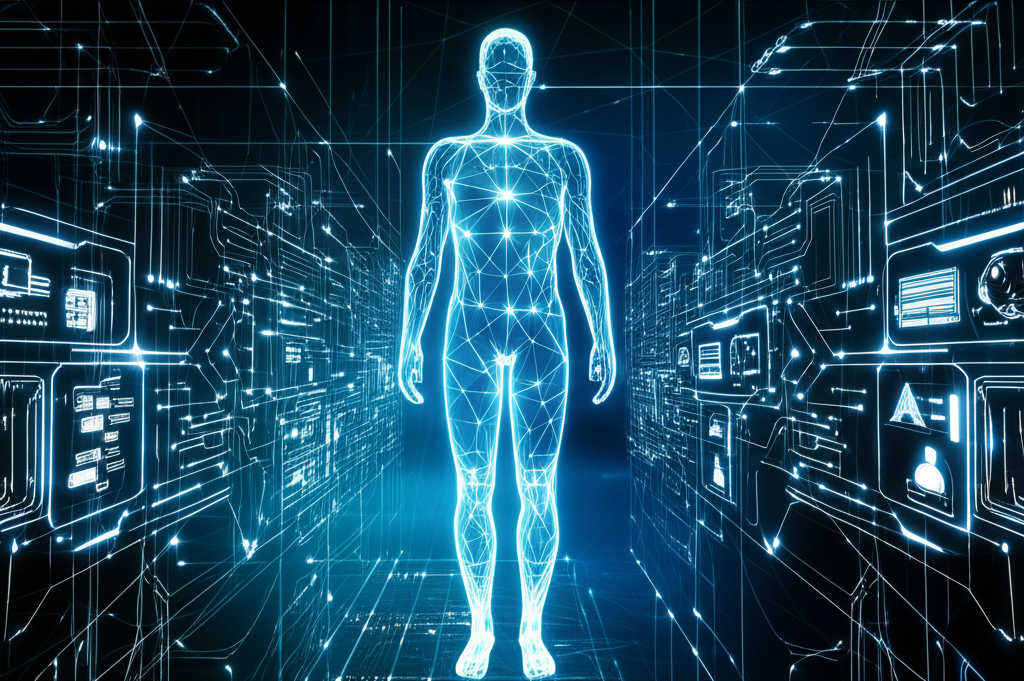

In [70]:

import base64

from IPython.display import Image, display
from langchain_core.messages import AIMessage
from langchain_google_genai import ChatGoogleGenerativeAI

image_gen_llm = ChatGoogleGenerativeAI(model="models/gemini-2.0-flash-preview-image-generation")

message = {
    "role": "user",
    "content": fimal_image_proompt.content,
}

response = image_gen_llm.invoke(
    [message],
    generation_config=dict(response_modalities=["TEXT", "IMAGE"]),
)


def _get_image_base64(response: AIMessage) -> None:
    image_block = next(
        block
        for block in response.content
        if isinstance(block, dict) and block.get("image_url")
    )
    return image_block["image_url"].get("url").split(",")[-1]


image_base64 = _get_image_base64(response)
display(Image(data=base64.b64decode(image_base64), width=1080))